In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

class Empresa:
    def __init__(self, nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem):
        self.nome = nome
        self.receita = receita
        self.propaganda = propaganda
        self.num_vendedores = num_vendedores
        self.salario_vendedores = salario_vendedores
        self.hora_extra = hora_extra
        self.estocagem = estocagem

    def calcular_despesas(self):
        salario_total = self.num_vendedores * self.salario_vendedores
        custo_hora_extra = self.hora_extra if self.hora_extra is not None else 0
        custo_estocagem = self.estocagem if self.estocagem is not None else 0

        despesas = {
            "Propaganda": self.propaganda,
            "Salário Vendedores": salario_total,
            "Hora Extra": custo_hora_extra,
            "Estocagem": custo_estocagem
        }

        return despesas

    def calcular_cmv(self):
        return 0.2 * self.receita

    def calcular_despesas_fixas(self):
        return {
            "Salários": 0.08 * self.receita,
            "Aluguel": 2000
        }

    def calcular_total_despesas(self):
        despesas = self.calcular_despesas()
        despesas_fixas = self.calcular_despesas_fixas()

        total_despesas = sum(despesas.values()) + sum(despesas_fixas.values())
        return total_despesas

    def calcular_resultado(self):
        return self.receita - self.calcular_cmv() - self.calcular_total_despesas()

    def esta_falida(self):
        return self.calcular_resultado() < 0

class SimuladorEmpresas:
    def __init__(self, num_empresas):
        self.empresas = []
        self.num_empresas = num_empresas
        self.resultados = []  # Store results here

    def criar_empresas_aleatorias(self):
        for i in range(self.num_empresas):
            nome = f"Empresa {i+1}"
            receita = random.uniform(0, 1000000)  # Random revenue
            propaganda = random.uniform(0, 10000)  # Random advertising expenses
            num_vendedores = random.randint(5, 100)  # Random number of employees
            salario_vendedores = random.uniform(1000, 2000)  # Random employee salaries
            hora_extra = random.uniform(0, 1000)  # Random overtime costs
            estocagem = random.uniform(0, 1000)  # Random storage costs

            empresa = Empresa(nome, receita, propaganda, num_vendedores, salario_vendedores, hora_extra, estocagem)
            self.empresas.append(empresa)

    def calcular_e_exibir_resultados(self):
        self.resultados = []  # Reset the results
        for empresa in self.empresas:
            resultado = empresa.calcular_resultado()
            self.resultados.append(resultado)

        classificacao = sorted(enumerate(self.resultados, start=1), key=lambda x: x[1])
        classificacao_final = {empresa[0]: i for i, empresa in enumerate(classificacao, start=1)}

        print("\nDemonstrativo de Resultados")
        print("Empresa\tResultado\tClassificação\tStatus")
        for i, (empresa, resultado) in enumerate(zip(self.empresas, self.resultados), start=1):
            status = "Falida" if empresa.esta_falida() else "Ativa"
            print(f"{empresa.nome}\t{resultado:.2f}\t\t{classificacao_final[i]}\t\t{status}")

    def plotar_grafico(self):
        data = {
            "Empresa": [empresa.nome for empresa in self.empresas],
            "Resultado": self.resultados,  # Use the stored results
            "Status": ["Falida" if empresa.esta_falida() else "Ativa" for empresa in self.empresas]
        }
        df = pd.DataFrame(data)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Empresa", y="Resultado", hue="Status", data=df)
        plt.title("Resultados das Empresas")
        plt.xlabel("Empresa")
        plt.ylabel("Resultado")
        plt.show()



Demonstrativo de Resultados
Empresa	Resultado	Classificação	Status
Empresa 1	26273.38		1		Ativa
Empresa 2	338750.14		4		Ativa
Empresa 3	324798.08		3		Ativa
Empresa 4	624090.02		5		Ativa
Empresa 5	31381.94		2		Ativa


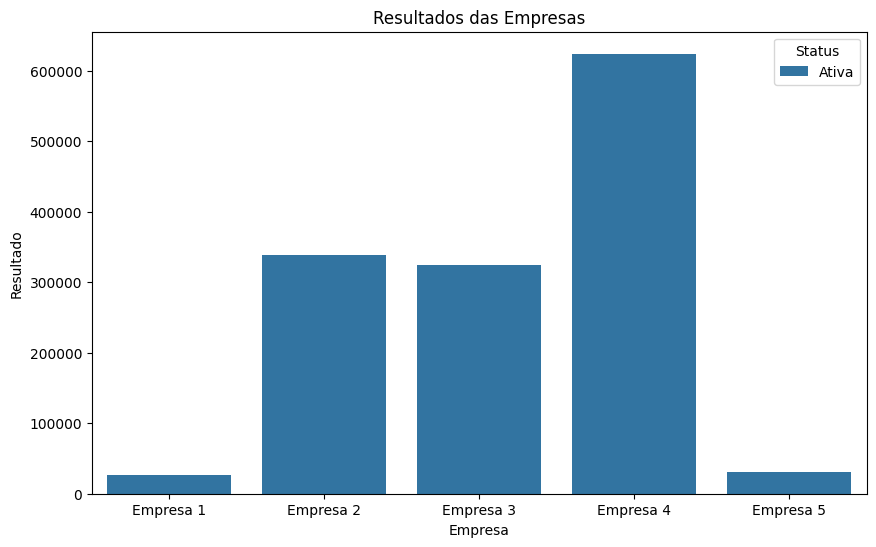

In [51]:
if __name__ == "__main__":
    num_empresas = 5  # Set the number of companies you want to simulate
    simulador = SimuladorEmpresas(num_empresas)
    simulador.criar_empresas_aleatorias()
    simulador.calcular_e_exibir_resultados()
    simulador.plotar_grafico()

